In [1]:
import psycopg2
from sqlalchemy import create_engine, Engine, TextClause, Text, ClauseElement, ExceptionContext
from sqlalchemy.orm import sessionmaker
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.axes import Axes
from matplotlib.axis import Axis

import seaborn as sns
import squarify
import plotly as py
import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)
from plotly.subplots import make_subplots

In [3]:
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
rcParams['font.size'] = 9
rcParams['lines.linewidth'] = 2
rcParams['figure.dpi'] = 150
rcParams['figure.figsize'] = (12,8)
rcParams['figure.facecolor'] = 'white'
rcParams['figure.edgecolor'] = 'white'
rcParams['axes.facecolor'] = 'white'
rcParams['axes.edgecolor'] = 'white'
rcParams['axes.grid'] = 'False'

In [5]:
customers = pd.read_csv('./superstore/superstore_customers.csv')
locations = pd.read_csv('./superstore/superstore_ship_locations.csv')
products = pd.read_csv('./superstore/superstore_products.csv')
orders = pd.read_csv('./superstore/superstore_orders.csv')
sales = pd.read_csv('./superstore/superstore_product_sales.csv')
returns = pd.read_csv('./superstore/superstore_returns.csv')

In [7]:
data_list = [customers, locations, products, orders, sales, returns]
for df in data_list:
    df.columns = [col.lower().replace(' ','_').strip() for col in df.columns]

### removed duplicates and save new cleaned data: 
#### (with cleaned data this section is not needed)


#### drop all product with the same id in products, sales tables to reduce ambiguity

In [279]:
duplicated_id = list(products.loc[products['product_id'].duplicated()].sort_values(by=['product_id'])['product_id'])
drop_index = products.loc[products['product_id'].isin(duplicated_id)].sort_values(by=['product_id']).index

In [287]:
products = products.drop(drop_index).reset_index(drop=True)
products.to_csv('./superstore/superstore_products.csv', index=False)

In [313]:
drop_index_sale = sales.loc[sales['product_id'].isin(duplicated_id)].sort_values(by=['product_id']).index
sales = sales.drop(drop_index_sale).reset_index(drop=True)


#### drop all duplicated orders

In [496]:
dup_sales = sales[['order_id', 'customer_id', 'product_id']].loc[sales[['order_id', 'customer_id', 'product_id']].duplicated()]
dup_order_index = dup_sales.index
sales = sales.drop(dup_order_index).reset_index(drop=True)
sales.to_csv('./superstore/superstore_product_sales.csv', index=False)

### Postgresql connection

In [9]:
pgengine = create_engine("postgresql+psycopg2://postgres:@localhost/SuperstoreSales")

### If all tables have been fetched/connected to DB, may skip this section.

In [ ]:
customers.to_sql('customers', con=pgengine, if_exists= 'replace', index=False)
locations.to_sql('ship_locations', con=pgengine, if_exists='replace', index=False)
products.to_sql('products', con=pgengine, if_exists='replace', index=False)
orders.to_sql('orders', con=pgengine, if_exists='replace', index=False)
sales.to_sql('product_sales', con=pgengine, if_exists='replace', index=False)
returns.to_sql('returns', con=pgengine, if_exists='replace', index=False)

#### error raised if existed

In [ ]:
customers.to_sql('customers', con=pgengine, if_exists= 'fail', index=False)
# locations.to_sql('customer_locations', con=pgengine, if_exists='fail', index=False)
# products.to_sql('products', con=pgengine, if_exists='fail', index=False)
# orders.to_sql('orders', con=pgengine, if_exists='fail', index=False)
# sales.to_sql('product_sales', con=pgengine, if_exists='fail', index=False)
# returns.to_sql('returns', con=pgengine, if_exists='fail', index=False)

### functions for use

In [11]:
def get_sql_query(query:str, connection:Engine= pgengine)-> DataFrame:
    return pd.read_sql(query, connection)
    

In [13]:
def add_text(ax:Axis| Axes , data:Series| DataFrame, horizontal:bool = True, dx:float=0, dy:int=11,  
             color:str='black', fontsize:float=9)->():
    for i, value in enumerate(data):
        if horizontal:
            ax.text(value+dy, i+dx, str(value), ha='center', va = 'center', fontsize=fontsize, color=color)
        else:
            ax.text(i+dx, value+dy, str(value), ha='center', va = 'center', fontsize=fontsize, color=color)

In [15]:
def create_view(query:str, conn:Engine = pgengine)->():
    try:
        conn = pgengine.connect()
        conn.execute(TextClause(query))
    except Exception as err:
        print(err)
    finally:
        conn.commit()
        conn.close()

### Initial EDA 

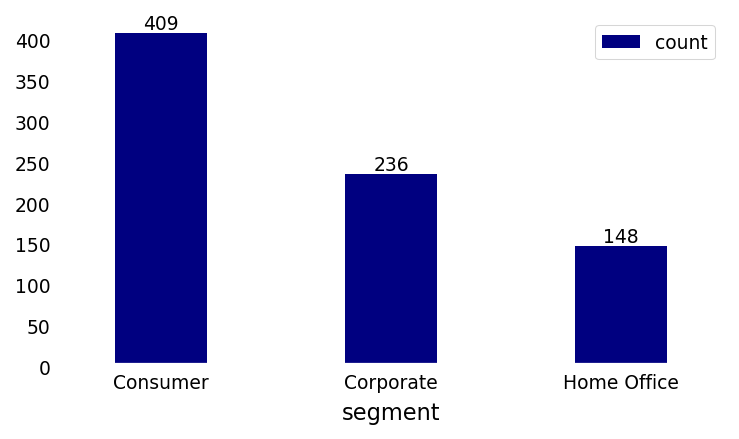

,segment,count
0,Consumer,409
1,Corporate,236
2,Home Office,148


In [17]:
customer_segment_count = """
    select segment, count(segment) from customers
    group by segment;
"""
df_cs = get_sql_query(customer_segment_count)
df_cs.plot(figsize=(5,3),kind='bar',x='segment', y='count',width=0.4, color='navy')
sns.despine()
add_text(plt, df_cs['count'], horizontal=False)
plt.xticks(rotation=360)
plt.tight_layout()
plt.show()
df_cs

In [18]:
sub_category = get_sql_query('select distinct sub_category, category from products order by category')
sub_category

,sub_category,category
0,Chairs,Furniture
1,Bookcases,Furniture
2,Furnishings,Furniture
3,Tables,Furniture
4,Binders,Office Supplies
5,Art,Office Supplies
6,Supplies,Office Supplies
7,Storage,Office Supplies
8,Envelopes,Office Supplies
9,Paper,Office Supplies


### Top City and State

In [22]:
cities_with_most_orders ="""
    select count(o.order_id) total_orders, s.city
    from orders o join ship_locations s 
    on o.postal_code = s.postal_code
    group by s.city
    order by total_orders desc 
    limit 10;
 """
df_top_ct = get_sql_query(cities_with_most_orders)
df_top_ct

,total_orders,city
0,450,New York City
1,384,Los Angeles
2,265,San Francisco
3,265,Philadelphia
4,212,Seattle
5,188,Houston
6,171,Chicago
7,111,Columbus
8,80,Dallas
9,73,Springfield


In [24]:
states_with_most_orders ="""
    select count(o.order_id) total_orders, s.state
    from orders o join ship_locations s 
    on o.postal_code = s.postal_code
    group by s.state
    order by total_orders desc 
    limit 10;
 """
df_top_st = get_sql_query(states_with_most_orders)
df_top_st

,total_orders,state
0,1021,California
1,562,New York
2,487,Texas
3,288,Pennsylvania
4,276,Illinois
5,256,Washington
6,236,Ohio
7,200,Florida
8,136,North Carolina
9,117,Michigan


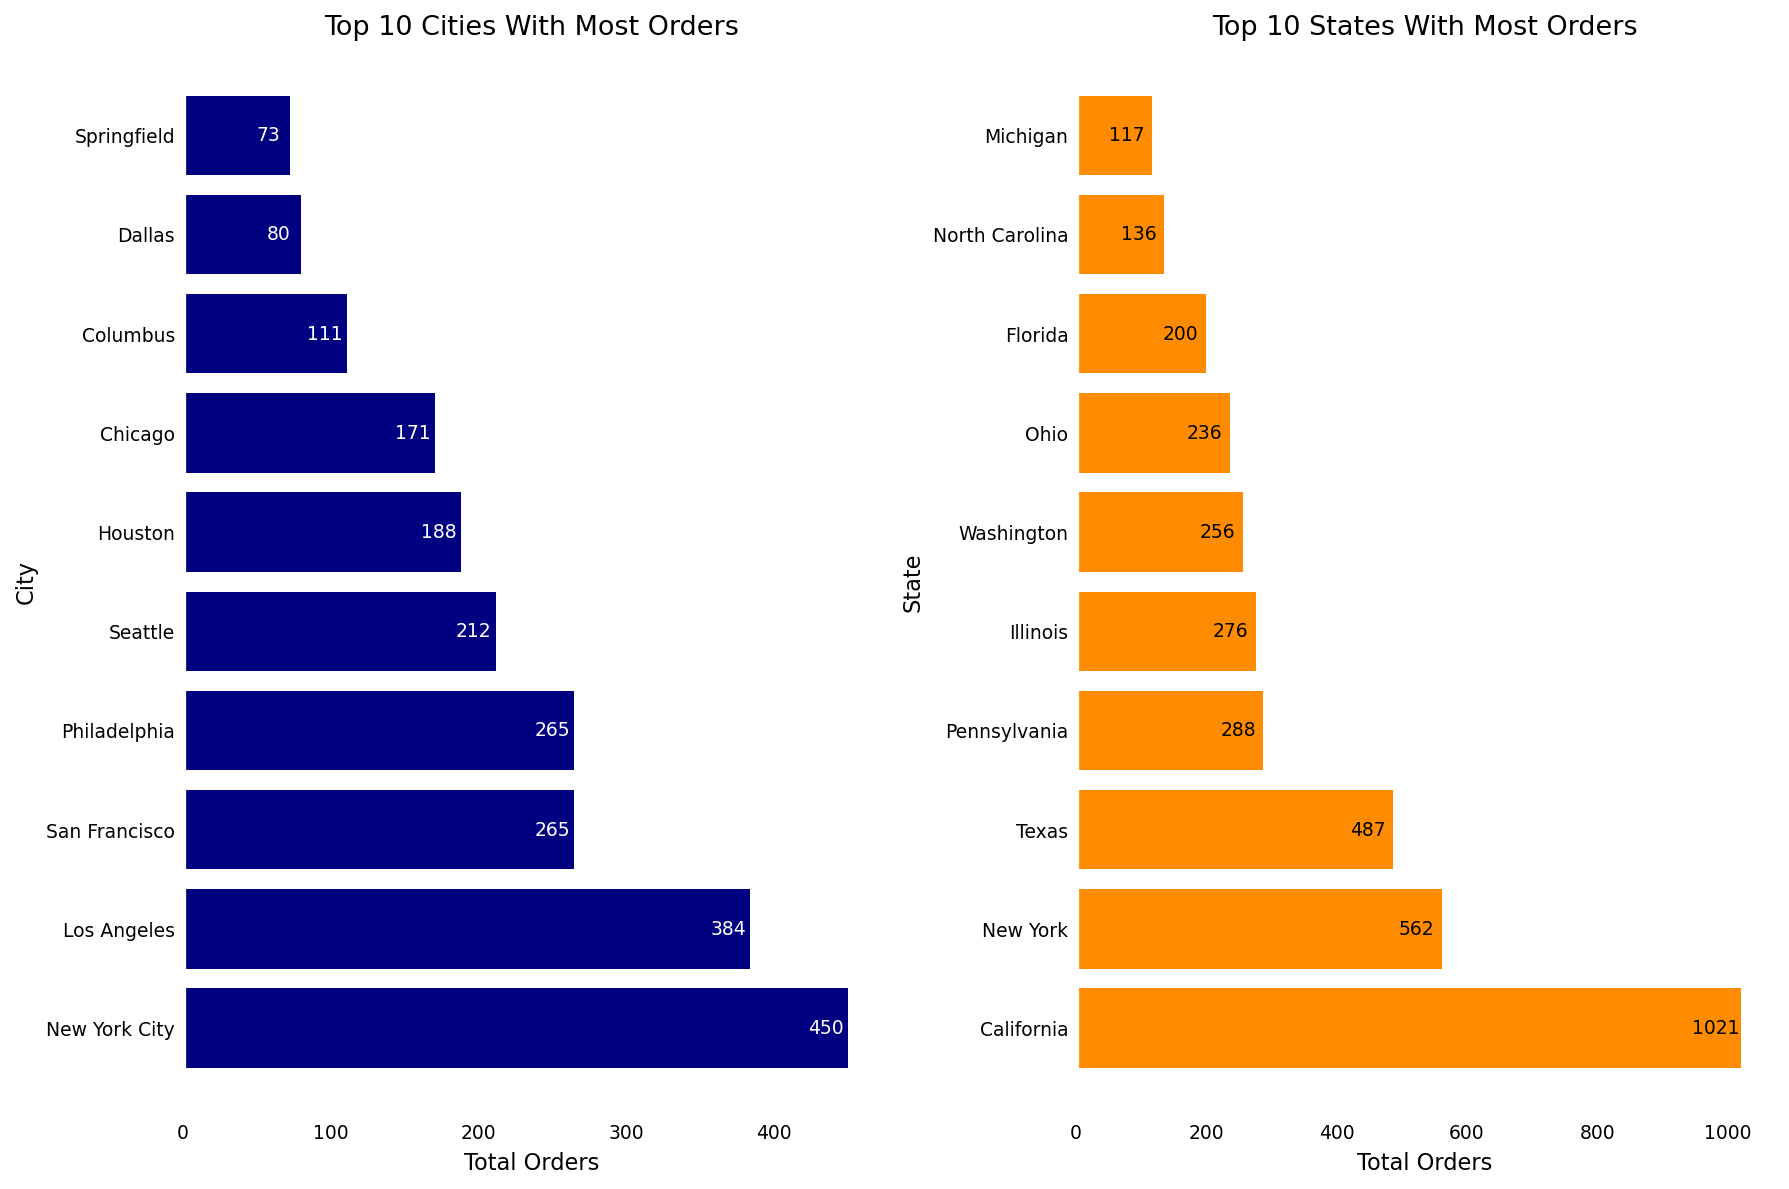

In [26]:
fig, axs = plt.subplots(1,2)
axs[0].barh(df_top_ct['city'],df_top_ct['total_orders'], color='navy')
axs[0].set_title('Top 10 Cities With Most Orders')
axs[0].set_ylabel('City')
axs[0].set_xlabel('Total Orders')
axs[1].barh(df_top_st['state'],df_top_st['total_orders'], color='darkorange')
axs[1].set_title('Top 10 States With Most Orders')
axs[1].set_ylabel('State')
axs[1].set_xlabel('Total Orders')

add_text(axs[0], df_top_ct['total_orders'], dy=-15, color='white', fontsize=9)
add_text(axs[1], df_top_st['total_orders'], dy=-39, color='black', fontsize=9)
sns.despine(bottom=True)
plt.tight_layout()
plt.show()

### Added Views

In [77]:
view_order_sales = """
    create or replace view order_sales_overview as 
        select ps.*, pd.product_name, pd.sub_category, pd.category, to_date(o.order_date, 'DD/MM/YY') order_date, 
        to_date(o.ship_date, 'DD/MM/YY') ship_date, o.ship_mode  from product_sales ps
        join products pd using (product_id)
        join orders o using (order_id);
"""
create_view(view_order_sales)

#### Calculate Unit Prices

In [79]:
# compute unit price for each product i.e before discount and create view
view_unit_prices = """
    create or replace view unit_price_overview as
    	with unit_prices as(
    		select order_id, order_date, customer_id, product_id, product_name, sub_category,category, sales, quantity, discount, profit,  
    		round(cast( sales / (1- discount) / quantity as numeric), 2) as unit_price
    		from order_sales_overview
    		),
    		product_unit_prices as(
    		select distinct product_id, unit_price, product_name, sub_category, category from unit_prices
    		)
        	select * from product_unit_prices order by sub_category;
            """
create_view(view_unit_prices)

### MORE EDA

In [28]:
product_unit_prices = get_sql_query('''select product_id, product_name, unit_price, sub_category, category from unit_price_overview''')
product_unit_prices

,product_id,product_name,unit_price,sub_category,category
0,TEC-AC-10002567,Logitech G602 Wireless Gaming Mouse,79.99,Accessories,Technology
1,TEC-AC-10003441,Kingston Digital DataTraveler 32GB USB 2.0,16.95,Accessories,Technology
2,TEC-AC-10004209,Memorex Froggy Flash Drive 4 GB,10.99,Accessories,Technology
3,TEC-AC-10001445,Imation USB 2.0 Swivel Flash Drive USB flash d...,3.03,Accessories,Technology
4,TEC-AC-10000109,Sony Micro Vault Click 16 GB USB 2.0 Flash Drive,55.99,Accessories,Technology
...,...,...,...,...,...
1825,FUR-TA-10003238,"Chromcraft Bull-Nose Wood 48"" x 96"" Rectangula...",550.98,Tables,Furniture
1826,FUR-TA-10002228,"Bevis Traditional Conference Table Top, Plinth...",333.36,Tables,Furniture
1827,FUR-TA-10002530,"Iceberg OfficeWorks 42"" Round Tables",150.98,Tables,Furniture
1828,FUR-TA-10004619,Hon Non-Folding Utility Tables,159.31,Tables,Furniture


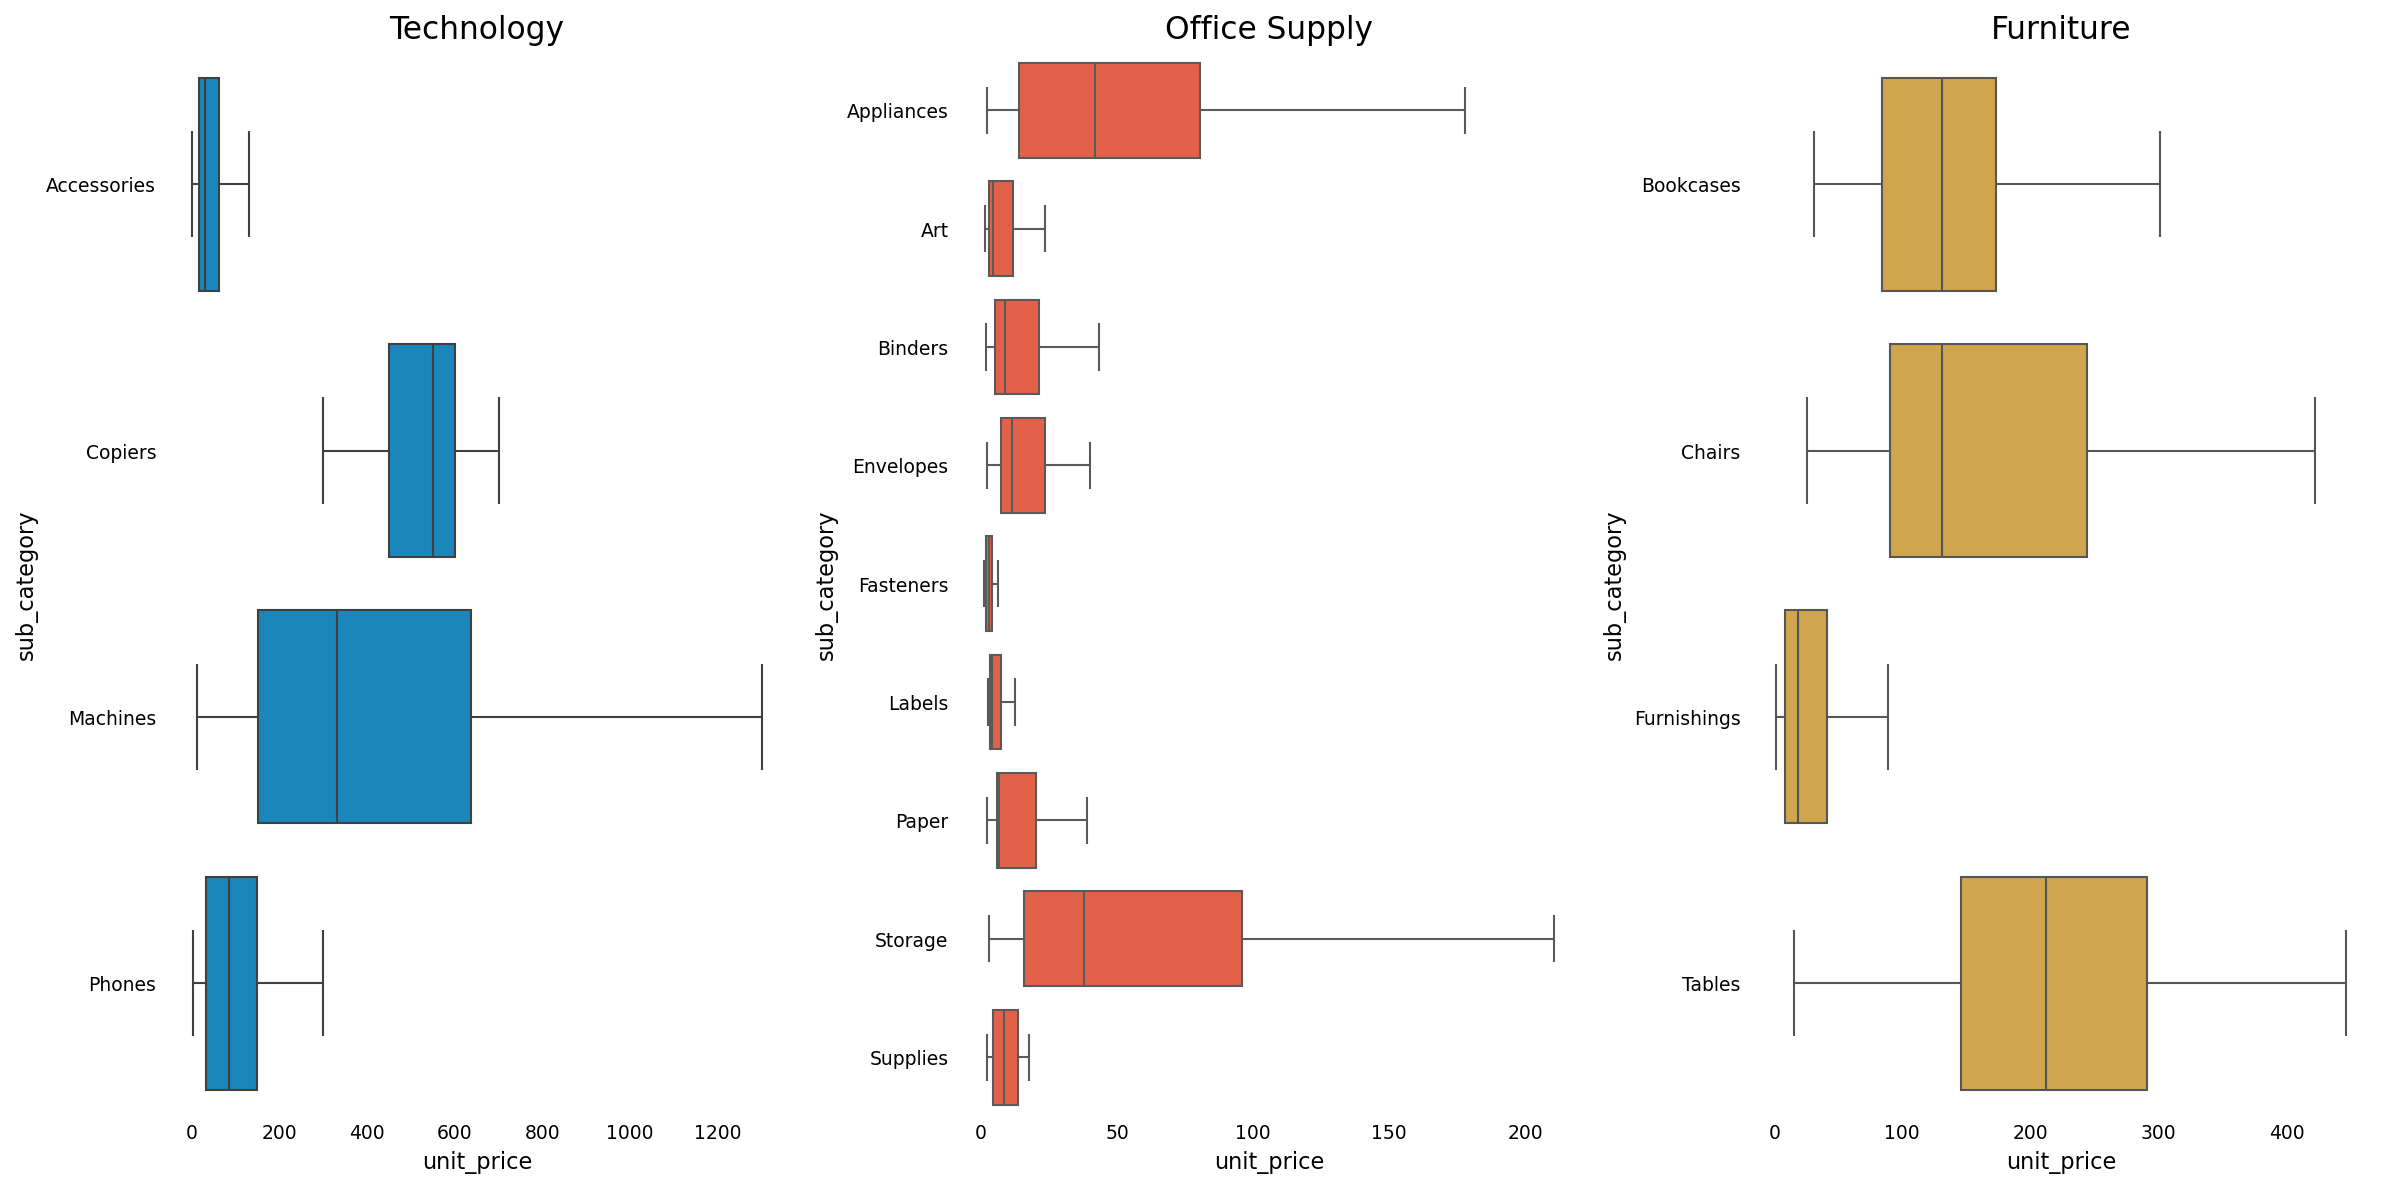

In [123]:
tech_sub_category_prices = get_sql_query("""select sub_category, unit_price, category 
                                        from unit_price_overview where category = 'Technology'
                                        order by sub_category """)
off_sub_category_prices = get_sql_query("""select sub_category, unit_price, category 
                                        from unit_price_overview where category = 'Office Supplies'
                                        order by sub_category """)
fur_sub_category_prices = get_sql_query("""select sub_category, unit_price, category 
                                        from unit_price_overview where category = 'Furniture'
                                        order by sub_category """)
fig, axs = plt.subplots(1,3, figsize=(16,8))
sns.boxplot(tech_sub_category_prices, y='sub_category', x='unit_price',ax=axs[0], showfliers=False)
sns.boxplot(off_sub_category_prices, y='sub_category', x='unit_price', ax=axs[1], showfliers=False, color='#fc4f30')
sns.boxplot(fur_sub_category_prices, y='sub_category', x='unit_price', ax=axs[2], showfliers=False, color='#e5ae38')
axs[0].set_title('Technology', fontsize=15)
axs[1].set_title('Office Supply', fontsize=15)
axs[2].set_title('Furniture', fontsize=15)
plt.tight_layout()
plt.show()

In [1470]:
top5_most_profitable_sub_cat = """
    select category, sub_category, round(cast(sum(profit) as numeric), 2)  total_profits
    from order_sales_overview 
    group by sub_category, category order by total_profits desc 
    limit 10
"""
df_profit_sub_pd = get_sql_query(top5_most_profitable_sub_cat)

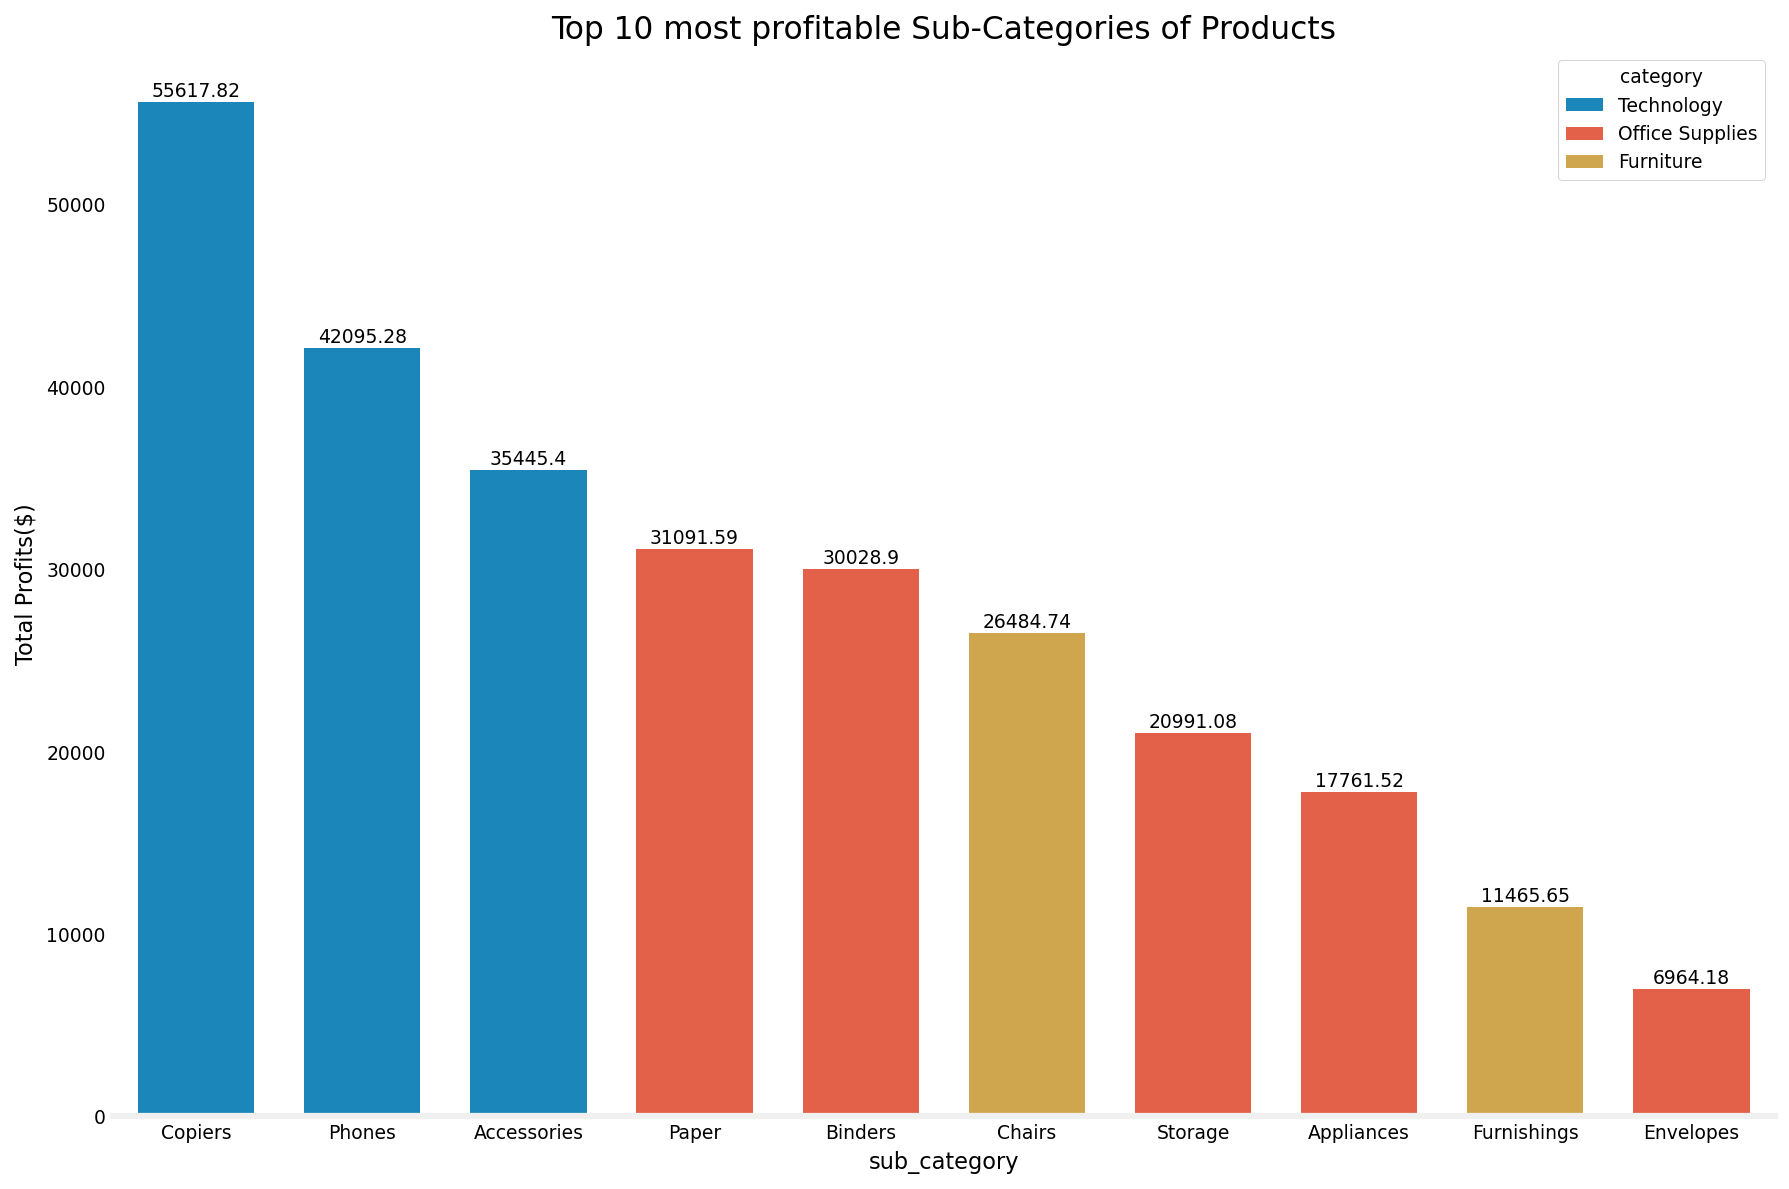

,category,sub_category,total_profits
0,Technology,Copiers,55617.82
1,Technology,Phones,42095.28
2,Technology,Accessories,35445.40
3,Office Supplies,Paper,31091.59
4,Office Supplies,Binders,30028.90
5,Furniture,Chairs,26484.74
6,Office Supplies,Storage,20991.08
7,Office Supplies,Appliances,17761.52
8,Furniture,Furnishings,11465.65
9,Office Supplies,Envelopes,6964.18


In [1709]:
sns.barplot(df_profit_sub_pd, x='sub_category', y='total_profits', hue='category',hue_order=['Technology','Office Supplies','Furniture'], width=0.7)
add_text(plt,df_profit_sub_pd['total_profits'], horizontal=False, dy=600)
sns.despine(left=True)
plt.title('Top 10 most profitable Sub-Categories of Products', fontsize=15)
plt.ylabel('Total Profits($)')
plt.tight_layout()
plt.show()
df_profit_sub_pd

In [1662]:
most_sold_products = """
    select product_id, product_name, cast(sum(quantity) as int) total_quantity
    from order_sales_overview
    group by product_id, product_name order by sum(quantity) desc
    limit 10
"""
top10_most_sold_products = get_sql_query(most_sold_products)

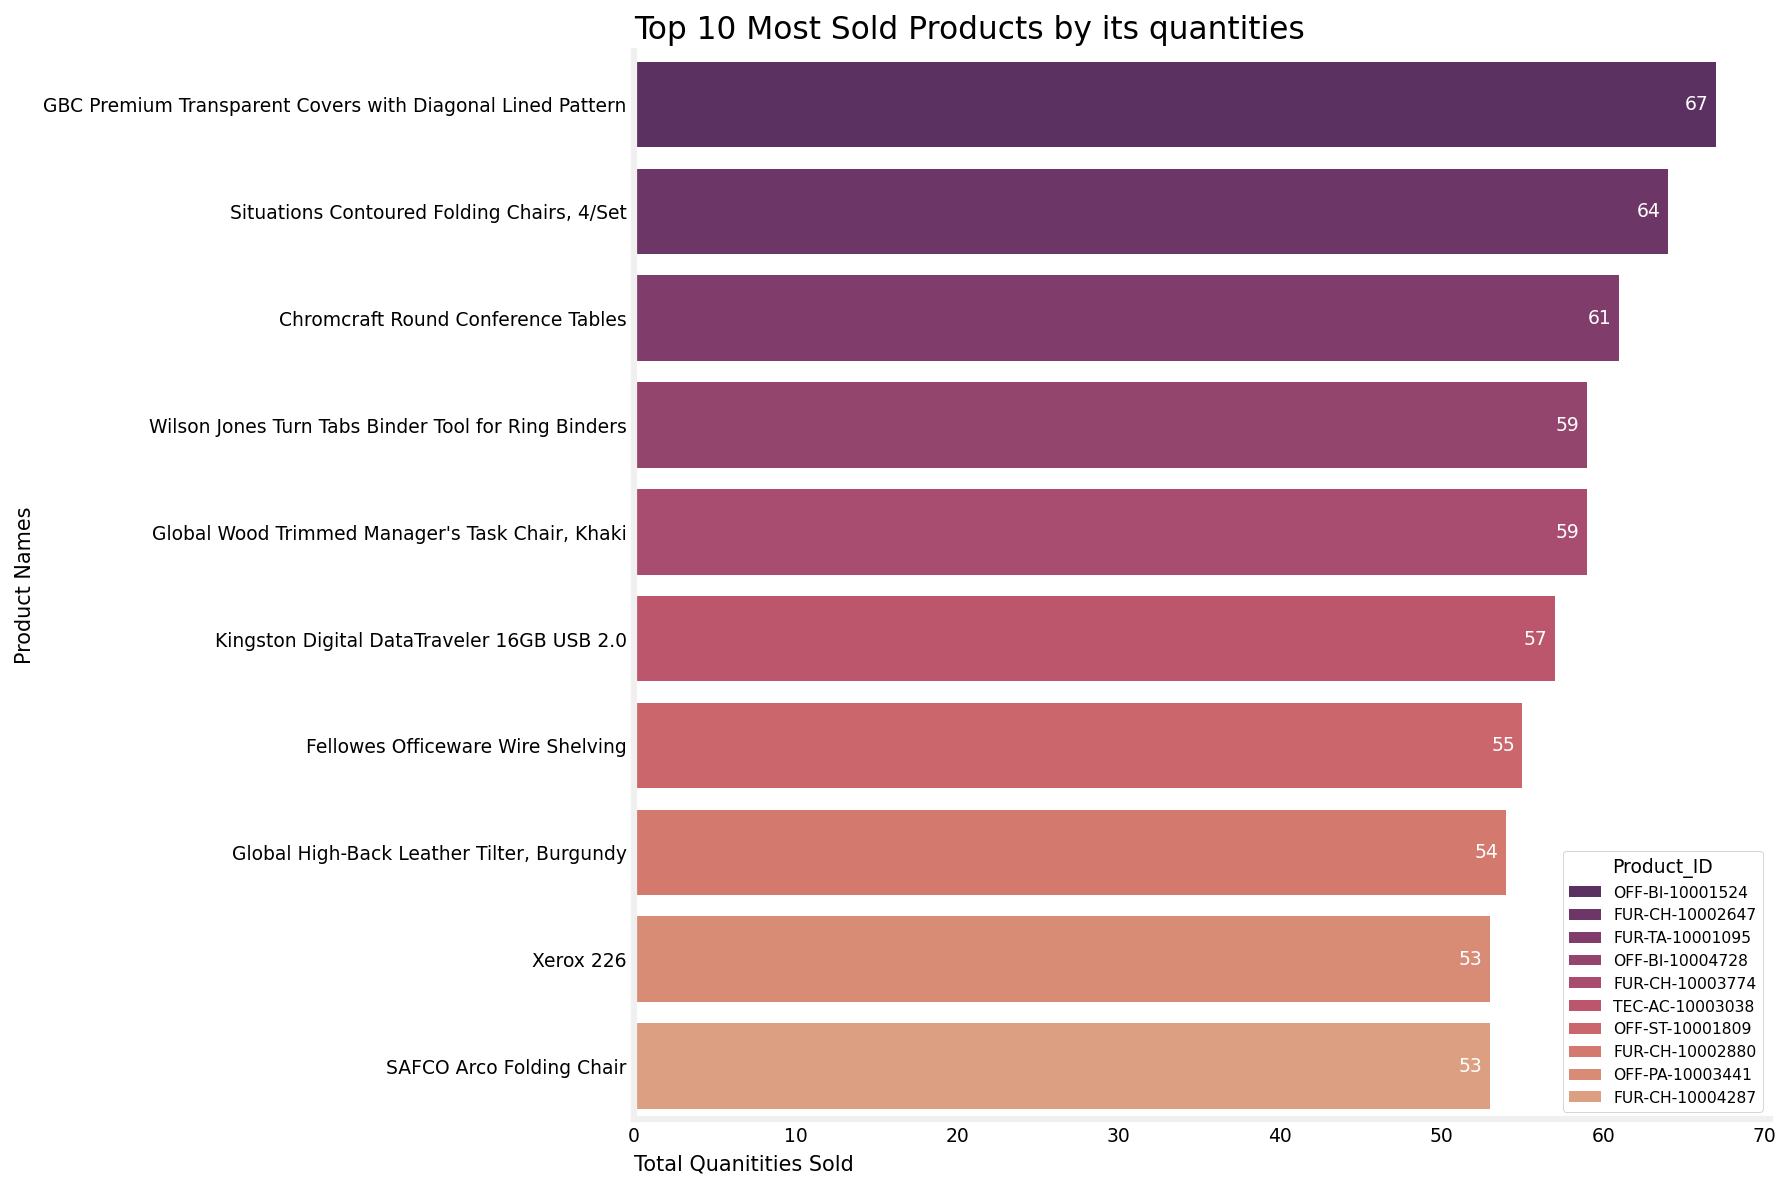

,product_id,product_name,total_quantity
0,OFF-BI-10001524,GBC Premium Transparent Covers with Diagonal L...,67
1,FUR-CH-10002647,"Situations Contoured Folding Chairs, 4/Set",64
2,FUR-TA-10001095,Chromcraft Round Conference Tables,61
3,OFF-BI-10004728,Wilson Jones Turn Tabs Binder Tool for Ring Bi...,59
4,FUR-CH-10003774,"Global Wood Trimmed Manager's Task Chair, Khaki",59
5,TEC-AC-10003038,Kingston Digital DataTraveler 16GB USB 2.0,57
6,OFF-ST-10001809,Fellowes Officeware Wire Shelving,55
7,FUR-CH-10002880,"Global High-Back Leather Tilter, Burgundy",54
8,OFF-PA-10003441,Xerox 226,53
9,FUR-CH-10004287,SAFCO Arco Folding Chair,53


In [1684]:
sns.barplot(top10_most_sold_products, x='total_quantity', y='product_name', hue='product_id', palette='flare_r')
add_text(plt, top10_most_sold_products['total_quantity'], dy=-1.2, color='white', fontsize=9)
plt.title('Top 10 Most Sold Products by its quantities', loc='left', fontsize=15)
plt.yticks(fontsize=9)
plt.xlabel('Total Quanitities Sold',loc='left', fontsize=10)
plt.ylabel('Product Names', fontsize=10)
plt.legend(title='Product_ID',fontsize='small')
sns.despine()
plt.tight_layout()
plt.show()
top10_most_sold_products

In [946]:
top10_most_profit_products = """
    select product_id ,product_name, round(cast(sum(profit) as numeric), 2)  total_profits
    from order_sales_overview 
    group by product_name, product_id order by total_profits desc limit 10;
"""
df_top_profit_pd = get_sql_query(top10_most_profit_products)

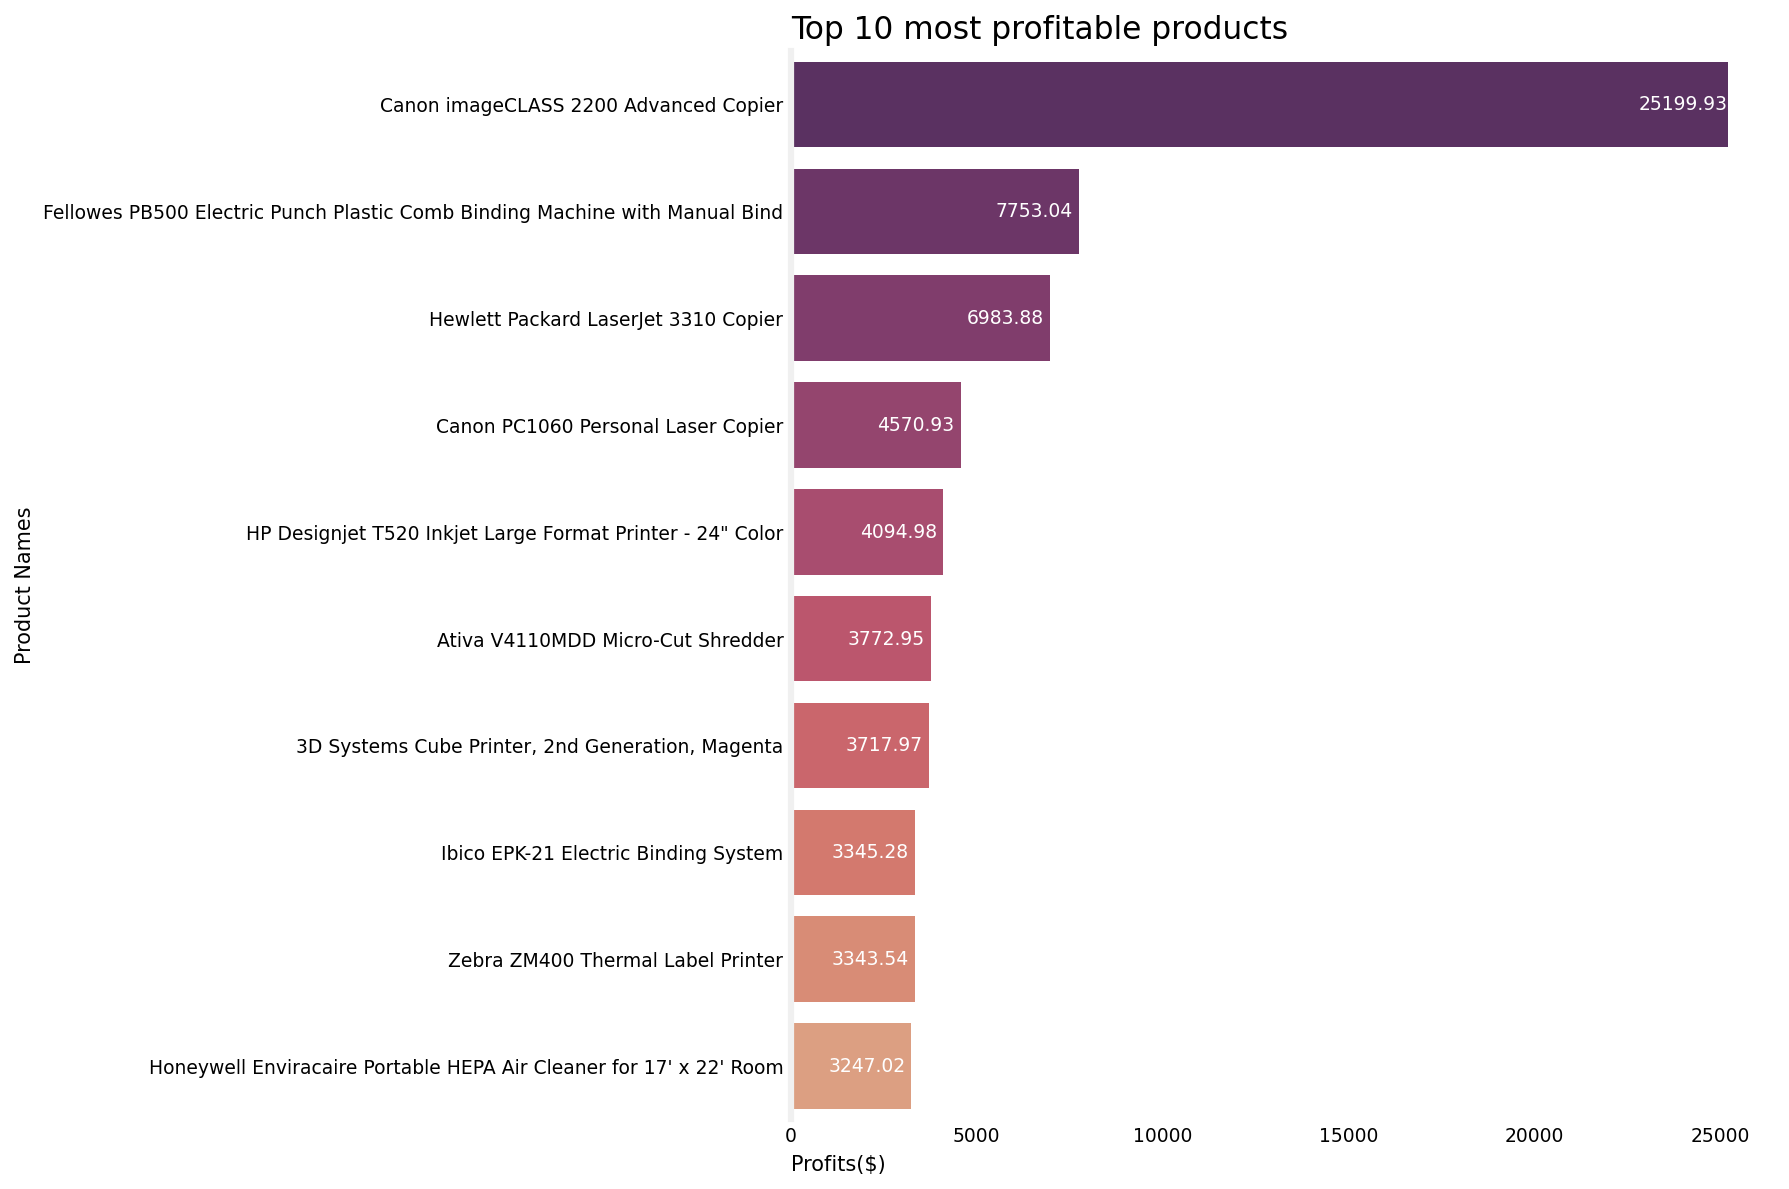

,product_id,product_name,total_profits
0,TEC-CO-10004722,Canon imageCLASS 2200 Advanced Copier,25199.93
1,OFF-BI-10003527,Fellowes PB500 Electric Punch Plastic Comb Bin...,7753.04
2,TEC-CO-10001449,Hewlett Packard LaserJet 3310 Copier,6983.88
3,TEC-CO-10003763,Canon PC1060 Personal Laser Copier,4570.93
4,TEC-MA-10001127,HP Designjet T520 Inkjet Large Format Printer ...,4094.98
5,TEC-MA-10003979,Ativa V4110MDD Micro-Cut Shredder,3772.95
6,TEC-MA-10001047,"3D Systems Cube Printer, 2nd Generation, Magenta",3717.97
7,OFF-BI-10001120,Ibico EPK-21 Electric Binding System,3345.28
8,TEC-MA-10000045,Zebra ZM400 Thermal Label Printer,3343.54
9,OFF-AP-10002945,Honeywell Enviracaire Portable HEPA Air Cleane...,3247.02


In [1686]:
sns.barplot(df_top_profit_pd, x='total_profits', y='product_name', hue='product_name', palette='flare_r')
plt.title('Top 10 most profitable products', loc='left', fontdict={'fontsize':15})
add_text(plt,df_top_profit_pd['total_profits'], dy=-1200, color='white', fontsize=9)
plt.ylabel('Product Names', fontsize=10)
plt.xlabel('Profits($)', fontsize=10, loc='left')
plt.yticks(fontsize=9)
plt.tight_layout()
sns.despine(bottom=True)
plt.show()
df_top_profit_pd

In [940]:
days_of_week_orders = """with days_of_week as(
	select order_id, extract(dow from order_date) dow, order_date
	from order_sales_overview
	order by order_date),
	day_names as(
	select order_id, dow,
	case
		when dow = 0 then 'SUN'
		when dow = 1 then 'MON'
		when dow = 2 then 'TUE'
		when dow = 3 then 'WED'
		when dow = 4 then 'THU'
		when dow = 5 then 'FRI'
		when dow = 6 then 'SAT'
	end as day_of_week, order_date
	from days_of_week)
	select count(order_id) total_orders, day_of_week from day_names
	group by day_of_week, dow order by dow
"""
dow_orders = get_sql_query(days_of_week_orders)

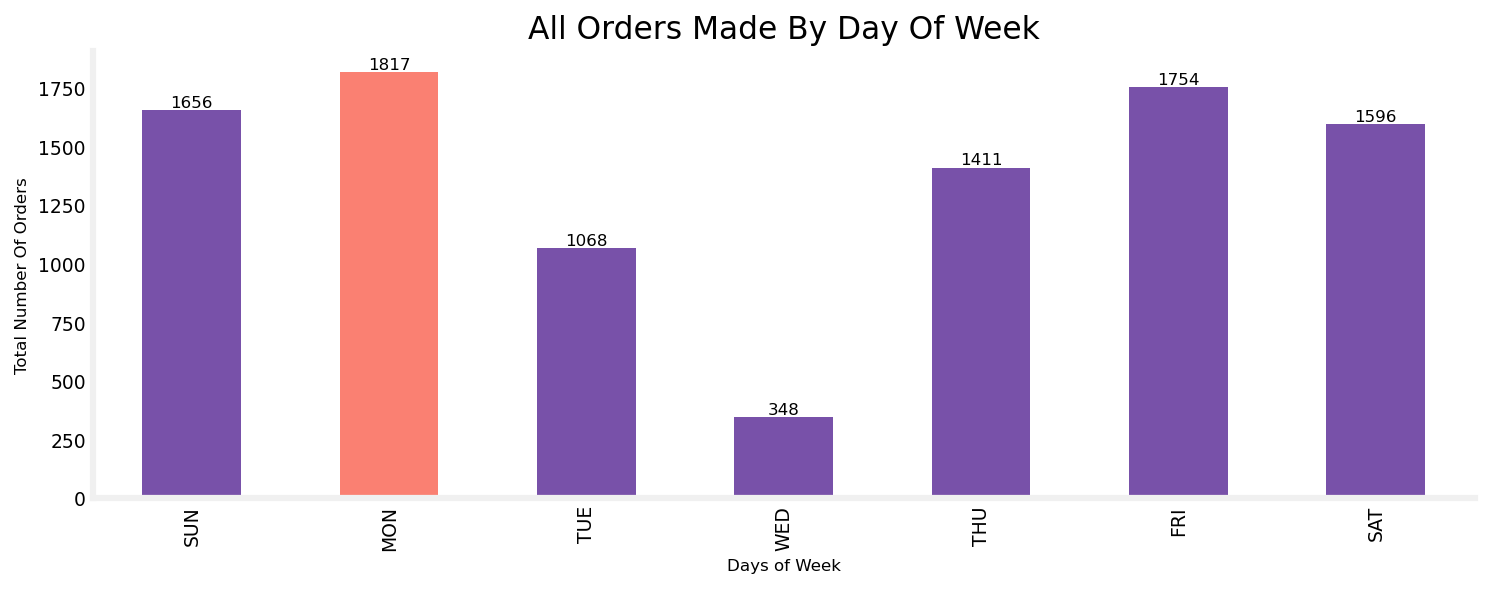

,total_orders,day_of_week
0,1656,SUN
1,1817,MON
2,1068,TUE
3,348,WED
4,1411,THU
5,1754,FRI
6,1596,SAT


In [1711]:
dow_orders.plot(kind='bar', x='day_of_week', y='total_orders',figsize=(10,4), 
                color=['salmon' if total == dow_orders['total_orders'].max() else '#7851A9' for total in dow_orders['total_orders']],
               legend=False)
add_text(plt,dow_orders['total_orders'], horizontal=False, dy=30, fontsize=8)
sns.despine()
plt.title('All Orders Made By Day Of Week', fontdict={'fontsize':15})
plt.ylabel('Total Number Of Orders', fontsize=8)
plt.xlabel('Days of Week',fontsize=8)
plt.tight_layout()
plt.show()
dow_orders

In [125]:
monthly_sales_profits = """
with year_month_day as(
	select order_id, customer_id, product_id, sales, quantity, profit, order_date,
	extract(year from order_date) as years,
	extract(month from order_date) as months
	from order_sales_overview
	order by order_date),
	sales_profits as (
	select months, years, case
			when months = 1 then 'JAN'
			when months = 2 then 'FEB'
			when months = 3 then 'MAR'
			when months = 4 then 'APR'
			when months = 5 then 'MAY'
			when months = 6 then 'JUN'
			when months = 7 then 'JUL'
			when months = 8 then 'AUG'
			when months = 9 then 'SEP'
			when months = 10 then 'OCT'
			when months = 11 then 'NOV'
			when months = 12 then 'DEC'
			end as month_name,
	round(cast(sum(sales) as numeric),2) total_sales, 
	round(cast(sum(profit) as numeric),2) total_profits
	from year_month_day
	group by months, years order by years, months)
select concat(month_name,'-',years) month_year, total_sales, total_profits from sales_profits
"""
monthly_df = get_sql_query(monthly_sales_profits)
monthly_df

,month_year,total_sales,total_profits
0,JAN-2014,13494.12,2209.79
1,FEB-2014,4407.10,822.69
2,MAR-2014,54342.14,66.19
3,APR-2014,27386.95,3336.87
4,MAY-2014,22752.47,2728.69
5,JUN-2014,34579.58,4971.08
6,JUL-2014,33495.22,-931.64
7,AUG-2014,26319.10,5175.70
8,SEP-2014,80455.20,8794.21
9,OCT-2014,31245.30,3394.64


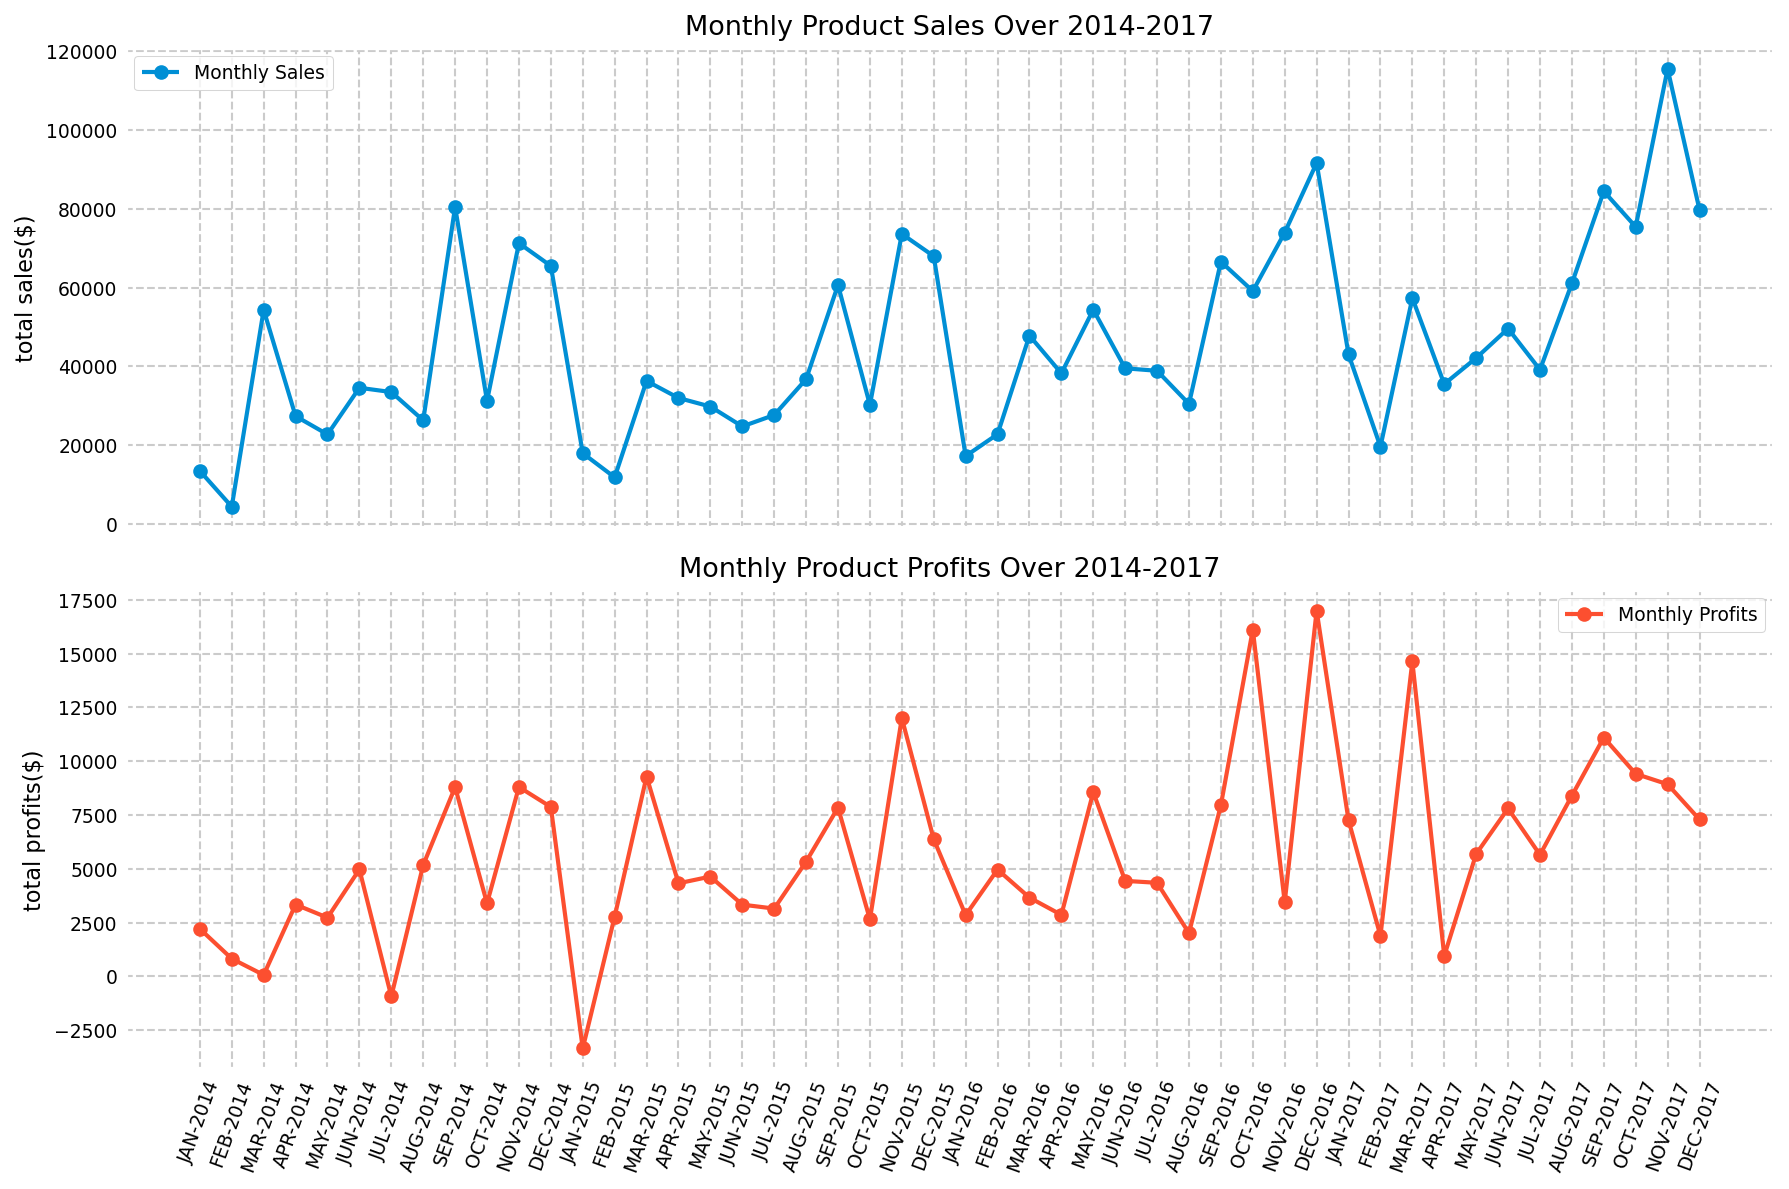

In [127]:
axes = monthly_df.plot(marker='o', subplots=True, sharex=True)
axes[0].set_ylabel('total sales($)')
axes[0].legend(labels = ['Monthly Sales'])
axes[0].set_title('Monthly Product Sales Over 2014-2017')
axes[0].grid(linestyle='--')
axes[1].set_ylabel('total profits($)')
axes[1].legend(labels = ['Monthly Profits'])
axes[1].set_title('Monthly Product Profits Over 2014-2017')
axes[1].grid(linestyle='--')
plt.xticks(ticks=range(len(monthly_df['month_year'])), labels=monthly_df['month_year'].tolist(), rotation=70)
plt.tight_layout()
plt.show()

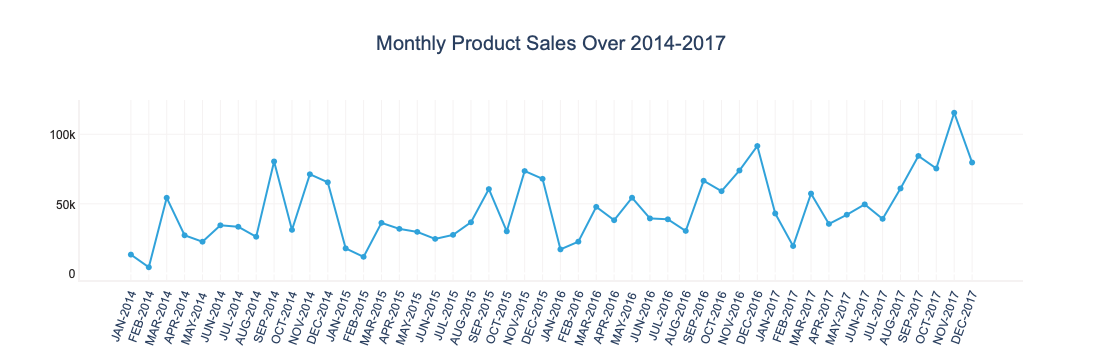

In [173]:
fig = go.Figure()
fig.add_trace(go.Scatter( 
    x = monthly_df['month_year'], 
    y = monthly_df['total_sales'],
    mode = 'lines + markers',
    name = 'Montly Sales',
    marker_color = '#30a2da',
))
# px.line(monthly_df, x='month_year', y='total_sales')
fig.update_layout(plot_bgcolor = 'white', title = 'Monthly Product Sales Over 2014-2017', 
                  title_font_family = 'Arial', title_font_size = 20, title_x = 0.5)
fig.update_xaxes(showline = True, linecolor = '#f5f2f2', showgrid = True, gridwidth = 1, gridcolor = '#f5f2f2',linewidth = 2, tickfont_family = 'Arial', tickfont_size = 12, tickangle =290)
fig.update_yaxes(showline = True, linecolor = '#f5f2f2', showgrid = True, gridwidth = 1, gridcolor = '#f5f2f2',
                 linewidth = 2, tickfont_family = 'Arial', tickfont_color = '#221f1f', tickfont_size = 12)
fig.show()

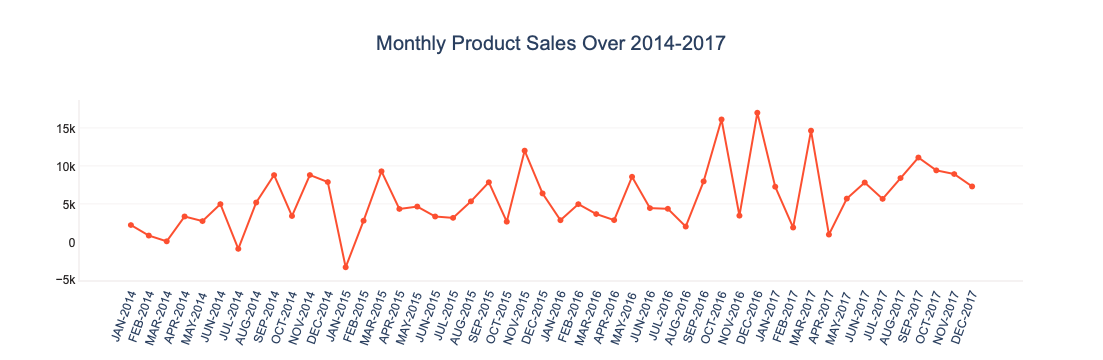

In [175]:
fig = go.Figure()
fig.add_trace(go.Scatter( 
    x = monthly_df['month_year'], 
    y = monthly_df['total_profits'],
    mode = 'lines + markers',
    name = 'Montly Sales',
    marker_color = '#fc4f30',
))
fig.update_layout(plot_bgcolor = 'white', title = 'Monthly Product Sales Over 2014-2017', 
                  title_font_family = 'Arial', title_font_size = 20, title_x = 0.5)
fig.update_xaxes(showline = True, linecolor = '#f5f2f2', linewidth = 2, tickfont_family = 'Arial', tickfont_size = 12, tickangle =290)
fig.update_yaxes(showline = True, linecolor = '#f5f2f2', showgrid = True, gridwidth = 1, gridcolor = '#f5f2f2',
                 linewidth = 2, tickfont_family = 'Arial', tickfont_color = '#221f1f', tickfont_size = 12)
fig.show()

### Customer Segementation

#### ranking the latest purchase by each customer

In [2172]:
most_recent = '''
select customer_id, max(order_date) most_recent_purchase,
rank() over(order by max(order_date) desc) rank
from order_sales_overview
group by customer_id
order by rank 
'''
get_sql_query(most_recent).head(10)

,customer_id,most_recent_purchase,rank
0,JM-15580,2017-12-30,1
1,CC-12430,2017-12-30,1
2,PO-18865,2017-12-30,1
3,EB-13975,2017-12-30,1
4,BS-11755,2017-12-29,5
5,MC-17845,2017-12-29,5
6,BP-11185,2017-12-29,5
7,KH-16360,2017-12-29,5
8,KB-16600,2017-12-29,5
9,JG-15160,2017-12-29,5


#### ranking most frequently ordered customers

In [2174]:
most_ordered = '''
select customer_id, count(order_id) order_frequency, 
rank() over (order by count(order_id) desc) as rank
from order_sales_overview
group by customer_id
order by rank limit 10
'''
get_sql_query(most_ordered)

,customer_id,order_frequency,rank
0,WB-21850,37,1
1,JL-15835,34,2
2,MA-17560,34,2
3,SV-20365,32,4
4,EH-13765,32,4
5,PP-18955,31,6
6,AP-10915,31,6
7,CK-12205,31,6
8,ZC-21910,30,9
9,EP-13915,30,9


#### ranking top spender customers

In [2176]:
top_spenders = '''
select customer_id,  round(cast(sum(sales) as numeric),2) total_purchases, 
rank() over(order by sum(sales) desc) as rank
from order_sales_overview
group by customer_id
order by rank limit 10
'''
get_sql_query(top_spenders)

,customer_id,total_purchases,rank
0,SM-20320,25012.28,1
1,TC-20980,18990.82,2
2,RB-19360,15117.34,3
3,TA-21385,14595.62,4
4,AB-10105,14128.87,5
5,KL-16645,14121.51,6
6,SC-20095,13886.57,7
7,HL-15040,12873.30,8
8,SE-20110,12187.45,9
9,CC-12370,11941.31,10


#### customer segmentation using RFM

rfm criterion ref: https://connectif.ai/en/blog/what-are-rfm-scores-and-how-to-calculate-them/

In [2158]:
rfm_scores = """
with rfm_scores as(
	select os.customer_id, c.customer_name, 
	ntile(5) over (order by max(os.order_date) desc) as recency_score,
	ntile(5) over (order by count(os.order_id) desc) as frequency_score,
	ntile(5) over( order by sum(os.sales) desc) as monetary_score 
	from order_sales_overview os
	join customers c
	using (customer_id)
	group by customer_id, customer_name order by customer_id
	),
	segments as(
	select customer_id, customer_name, r,f, m, rfm,
	case
		when rfm ~ '^[4-5][4-5][4-5]$' and rfm !~'444' then 'Champion'
		when rfm ~'^543|444|435|355|354|345|344|335$' then 'Loyalist'
		when rfm ~ '^[3-5][3-5][1-3]|323|423$' and rfm !~'^331|332|343|443$' then 'Potential Loyalist'
		when rfm ~ '^[4][1-2][1-2]|512|511|311$' then 'New Customer'
		when rfm in('525', '524', '523', '522', '521', '515', '514', '513', 
					'425','424', '413','414','415', '315', '314', '313') then 'Promising'
		when rfm in('535', '534', '443', '434', '343', '334', '325', '324') then 'Need Attention'
		when rfm in('155', '154', '144', '214','215','115', '114', '113' ) then 'Cannot Lose'
		when rfm in('331', '321', '312', '221', '213') then 'About To Sleep'
		when rfm in('255', '254', '245', '244', '253', '252', '243', '242', '235', '234', '225', '224', 
					'153', '152', '145', '143', '142', '135', '134', '133', '125', '124') then 'At Risk'
		when rfm in('332', '322', '231', '241', '251', '233', '232', '223', '222', 
					'132', '123', '122', '212', '211') then 'Hibernating'
		when rfm in('111', '112', '121', '131', '141', '151') then 'Lost'
		
	end as customer_segment
	from (select customer_id, customer_name, recency_score r, 
			frequency_score f, monetary_score m, 
			concat(recency_score,frequency_score, monetary_score) rfm from rfm_scores)
	)
     select customer_id, customer_name, r,f,m, customer_segment
     from segments order by 1

"""
df_rfm_all = get_sql_query(rfm_scores)
df_rfm_all

,customer_id,customer_name,r,f,m,customer_segment
0,AA-10315,Alex Avila,5,4,1,Potential Loyalist
1,AA-10375,Allen Armold,1,2,4,At Risk
2,AA-10480,Andrew Allen,5,3,3,Potential Loyalist
3,AA-10645,Anna Andreadi,3,1,1,New Customer
4,AB-10015,Aaron Bergman,5,5,5,Champion
...,...,...,...,...,...,...
788,XP-21865,Xylona Preis,2,1,3,About To Sleep
789,YC-21895,Yoseph Carroll,1,4,1,Lost
790,YS-21880,Yana Sorensen,1,3,1,Lost
791,ZC-21910,Zuschuss Carroll,3,1,1,New Customer


In [2108]:
count_rfm_segments = df_rfm_all.groupby(by=['customer_segment']).count().sort_values(by='customer_id')['customer_id']
count_rfm_segments

customer_segment
About To Sleep         37
Cannot Lose            39
Need Attention         39
Promising              43
Lost                   52
New Customer           62
Loyalist               74
Potential Loyalist     95
At Risk               101
Champion              113
Hibernating           138
Name: customer_id, dtype: int64

In [2164]:
labels = ["%s\n%.2f"%l +'%' for l in zip(count_rfm_segments.index, count_rfm_segments.values * 100/count_rfm_segments.values.sum())]

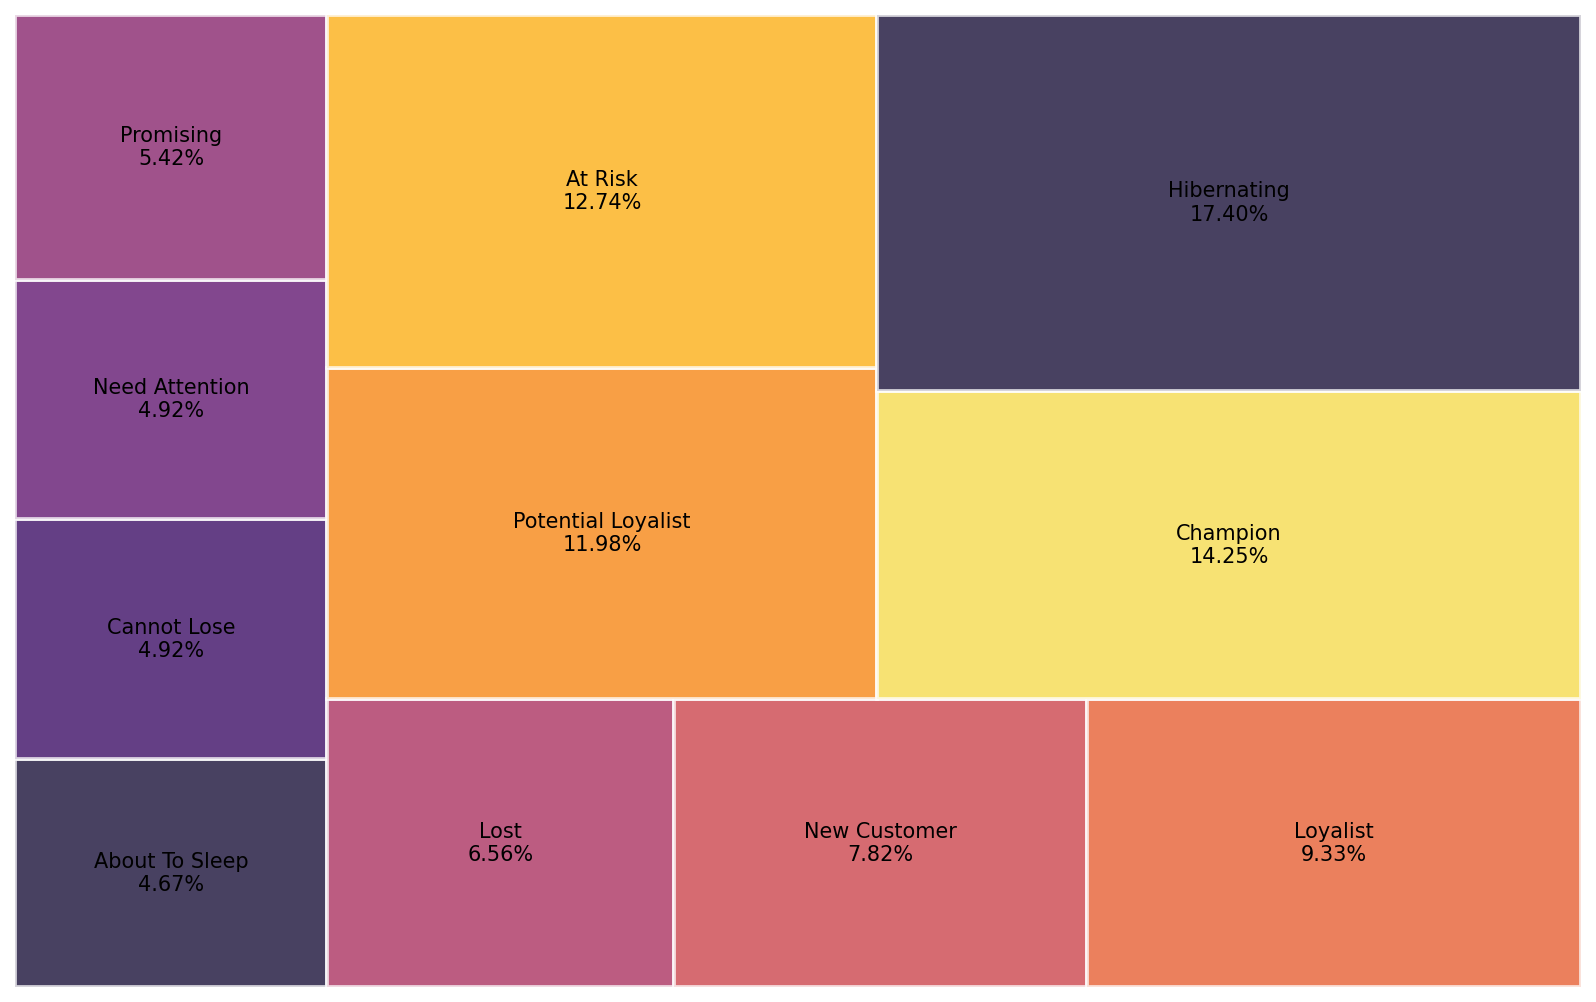

In [2202]:
palette = sns.color_palette(palette='inferno', n_colors=10)
squarify.plot(sizes=count_rfm_segments.values, label=labels, edgecolor='white', 
              linewidth=1.8, color=palette, alpha=0.78,text_kwargs={'fontsize':10, 'color':'black'})
plt.axis('off')
plt.show()

#### WordCloud for Product Names

In [1198]:
import string
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import re

In [1557]:
df = products[['product_name', 'sub-category']].copy()

In [1378]:
def clean_txt(text:str)-> str:
    
    text = text.lower().replace('\n', ' ')

    letters = list(string.ascii_lowercase)
    numbers = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    specials = ["’", "’", "“", "—", "”", '#', '[', '/',
              '(', ')', '{', '}', '\\', '[', ']', '|', '@', ',', ';', '+', '--']
    stops = ''.join(specials) + string.punctuation + ''.join(numbers)
    stop_list = set(stopwords.words('english') + letters)

    translation_table = dict.fromkeys(map(ord, stops), ' ')
    text = text.translate(translation_table)
    text = re.sub(' +', ' ', text)
    text = ' '.join([word for word in text.split() if word not in stop_list])
    return text

In [1545]:
product_names = clean_txt(str(list(df['product_name'])))

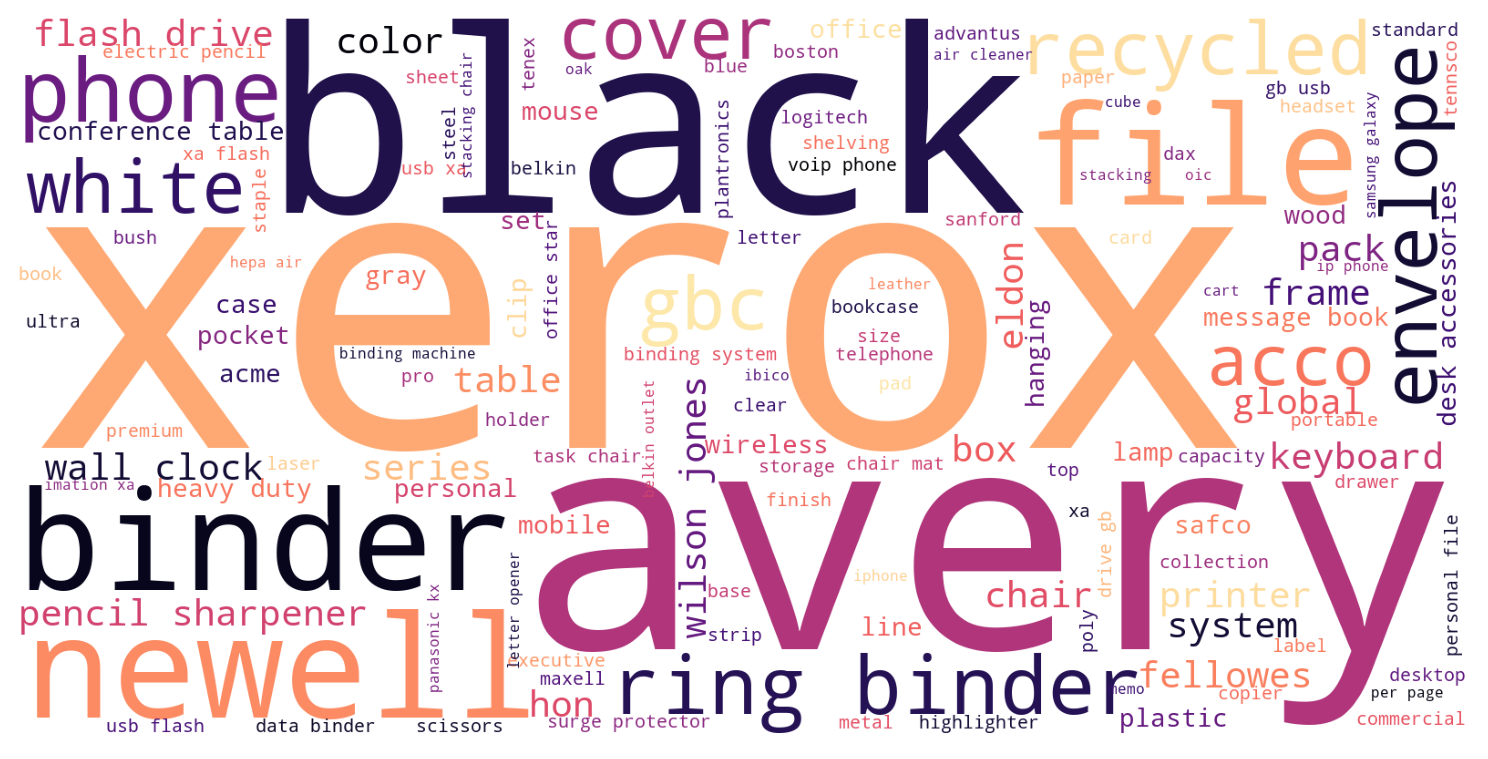

In [1608]:
wc = WordCloud(scale=4, max_words=800, background_color='white', colormap='magma' ).generate(product_names )
plt.imshow(wc)
plt.axis('off')
plt.show()